# Uncertainty estimation

This notebook performs uncertainty quantification for the U-Net model

In [ ]:
from pathlib import Path
import random

import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread

import torch
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from carde.io import image_path, tiled_image_path, tiled_label_path
from carde.dataset import SEMTileDataset, split_data
from carde.unet import SegmentationModel, learn_temperature_lbfgs
from carde.evalmetrics import (
    plot_as_confidence_map,
    plot_confidence_map,
    compute_nll,
    compute_ece,
    plot_reliability_diagram,
)

## Figure parameters

In [2]:

devices=(0,) # which GPU devices to use, e.g. (0,1) for multi-GPU training
device_name = "cuda"
_ = torch.manual_seed(42)
np.random.seed(5)
random.seed(23)

# figure parameters
plt.rcParams['svg.fonttype'] = 'none'  # editable text in svg vector formats
plt.rcParams['font.size'] = 8
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = plt.rcParams['xtick.labelsize']

# figure sizes
textwidth = 7.05  # inches
onecolumn = 3.42  # inches
# set the default figure size to one column width
plt.rcParams["figure.figsize"] = (textwidth, onecolumn)

figure_path = Path('../paper/figures')
figure_path.mkdir(parents=True, exist_ok=True)

## Image metadata for scale bars

In [3]:
pixel_size = 8  # nanometers per pixel
scale_bar_length = 300  # nanometers
scale_bar_length_px = scale_bar_length / pixel_size  # in pixels

## Data and model architecture

In [4]:
raw_image_path = image_path.parent.parent / "01-02"
se2_image = imread(raw_image_path / "Original SEM Images" / "WD_06mm_001.tif")
in_lens_image = imread(raw_image_path / "Original SEM Images" / "WD_06mm_002.tif")
label_image = imread(raw_image_path / "05a_Particle_Image_Filtered.bmp")

## Model training

In [5]:
model_path = tiled_label_path.parent.parent / "tb_logs"

In [6]:
# create dataset
dataset = SEMTileDataset(tiled_image_path, tiled_label_path, train=True)
# create dataloader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# split data into three sets: train, validation, and test
train_loader, val_loader, test_loader = split_data(dataset, batch_size=32, train_ratio=0.8, val_ratio=0.1)

In [7]:
print(f"Batches in training data loader: {len(train_loader)}")
print(f"Batches in validation data loader: {len(val_loader)}")
print(f"Batches in test data loader: {len(test_loader)}")

print(f"Number of samples in training data loader: {len(train_loader.dataset)}")
print(f"Number of samples in validation data loader: {len(val_loader.dataset)}")
print(f"Number of samples in test data loader: {len(test_loader.dataset)}")

total_samples = len(train_loader.dataset) + len(val_loader.dataset) + len(test_loader.dataset)
print(f"Total number of samples: {total_samples}")


Batches in training data loader: 48
Batches in validation data loader: 6
Batches in test data loader: 6
Number of samples in training data loader: 1536
Number of samples in validation data loader: 192
Number of samples in test data loader: 192
Total number of samples: 1920


In [8]:
# load existing model if available

model_path.mkdir(parents=True, exist_ok=True)
checkpoint_paths = list(model_path.glob("**/*.ckpt"))
if checkpoint_paths:
    print(f"Found existing checkpoints: {list(checkpoint_paths)}. Using the latest one for training.")
    checkpoint_path = max(checkpoint_paths, key=lambda p: p.stat().st_mtime)
    print(f"Loading checkpoint from {checkpoint_path}")
else:
    checkpoint_path = None
    print("No checkpoints found. Starting training from scratch.")

Found existing checkpoints: [PosixPath('../../data/cloud/tb_logs/unet_model/version_0/checkpoints/epoch=110-step=5328.ckpt')]. Using the latest one for training.
Loading checkpoint from ../../data/cloud/tb_logs/unet_model/version_0/checkpoints/epoch=110-step=5328.ckpt


In [9]:
# TensorBoard Logger
logger = TensorBoardLogger(str(model_path), name="unet_model")
logger

In [10]:
# training the model
model = SegmentationModel(
    in_channels=2, out_channels=1, lr=0.0002, lr_scheduler_patience=7, blocks=3, hidden_layers_block1=128
)

early_stop_callback = EarlyStopping(monitor="validation_loss", mode="min", patience=14, verbose=True)

trainer = pl.Trainer(max_epochs=1000, accelerator="gpu", enable_progress_bar=True, callbacks=[early_stop_callback], logger=logger)
if checkpoint_path is not None:
    trainer.fit(model, train_loader, val_loader, ckpt_path=str(checkpoint_path))
else:
    trainer.fit(model, train_loader, val_loader)

Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/home/korten76/workspace/chekhonin-automatic-carbide-detection/venv/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/korten76/workspace/chekhonin-automatic-carbide ...
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/korten76/workspace/chekhonin-automatic-carbide-detection/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/korten76/workspace/chekhonin-automatic-carbide-detection/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/korten76/workspace/chekhonin-automatic-carbide-detection/venv/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (48) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 15 records. Best score: 0.045. Signaling Trainer to stop.


## Temperature Scaling (UQ)

In [11]:
T = learn_temperature_lbfgs(model, val_loader, learning_rate=1, max_iter=100, device_name=device_name)

Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/home/korten76/workspace/chekhonin-automatic-carbide-detection/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to imp

Step   0 | T = 1.00000 | Loss = 0.01730
Step   1 | T = 1.01679 | Loss = 0.01703
Step   2 | T = 1.18114 | Loss = 0.01478
Step   3 | T = 2.50677 | Loss = 0.01439
Step   4 | T = 1.83866 | Loss = 0.01111
Step   5 | T = 1.87684 | Loss = 0.01111
Step   6 | T = 1.85962 | Loss = 0.01111
Step   7 | T = 1.85992 | Loss = 0.01111

Final Optimal Temperature T* = 1.8599


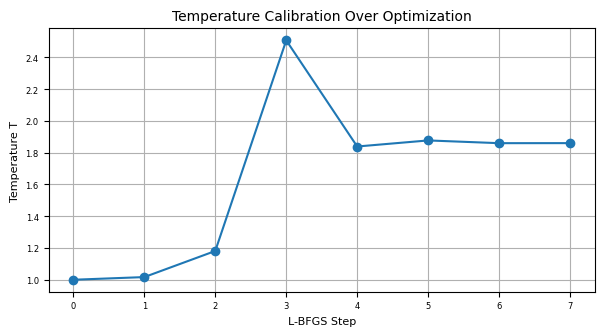

In [12]:
plt.plot(T[1], marker='o')
plt.xlabel("L-BFGS Step")
plt.ylabel("Temperature T")
plt.title("Temperature Calibration Over Optimization")
plt.grid(True)
plt.show()

In [13]:
optimal_T = T[0]
print(f"Optimal Temperature T*: {float(optimal_T):.4f}")


Optimal Temperature T*: 1.8599


## Evaluate temperature scaling success

### Predict logits and collect target label masks

In [14]:
logits = torch.cat(trainer.predict(model, test_loader), dim=0).to(device_name)
labels = torch.cat([l for _, l in test_loader], dim=0)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: |          | 0/? [00:00<?, ?it/s]

## Compute negative log likelyhood

In [15]:
nll_uncalibrated = compute_nll(logits, labels, temperature=None)
nll_calibrated = compute_nll(logits, labels, temperature=optimal_T.cpu())

In [16]:

print(f"\nNegative Log-Likelihood (Uncalibrated): {nll_uncalibrated:.4f}")
print(f"Negative Log-Likelihood (Calibrated):   {nll_calibrated:.4f}")


Negative Log-Likelihood (Uncalibrated): 0.0186
Negative Log-Likelihood (Calibrated):   0.0118


## Compute ECE

In [17]:
# Compute ECE on test set
ece_uncalibrated = compute_ece(logits, labels, temperature=None)
ece_calibrated = compute_ece(logits, labels, temperature=optimal_T)

print(f"\nECE (Uncalibrated): {ece_uncalibrated:.6f}")
print(f"ECE (Calibrated):   {ece_calibrated:.6f}")


ECE (Uncalibrated): 0.001798
ECE (Calibrated):   0.001460


## Plot reliability diagram

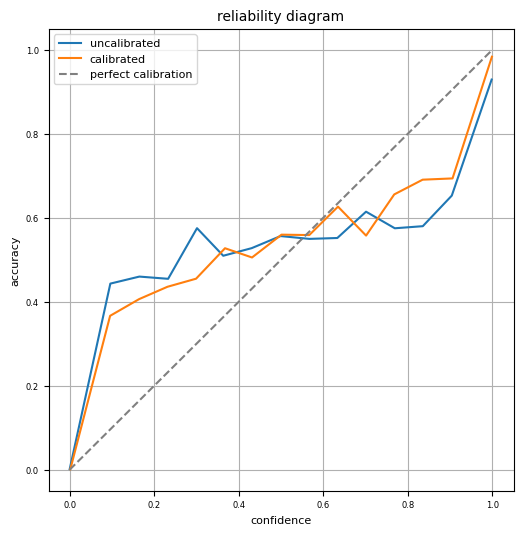

In [18]:
plot_reliability_diagram(logits, labels, temperature=optimal_T)

## Plot confidence map

In [19]:
def plot_confidence_map_and_input(
    model, trainer, test_loader, optimal_T, device=device_name, index=0, axs=None, fig=None
):
    if axs is None:
        fig, axs = plt.subplots(1, 3, figsize=(textwidth, textwidth/3.1))
    images, labels = test_loader.dataset[index]
    axs[0].imshow(images[1].cpu(), cmap="gray")
    axs[0].set_title("input image")
    axs[0].axis("off")
    labels[labels>0] = 3  # binarize for display
    plot_as_confidence_map(labels[0], ax=axs[1], fig=fig, color_bar=False)
    axs[1].set_title("target label")

    single_image_set = torch.utils.data.Subset(test_loader.dataset, [index])
    imageloader = torch.utils.data.DataLoader(single_image_set, batch_size=1)

    plot_confidence_map(model, trainer, imageloader, optimal_T, device=device, ax=axs[2], fig=fig)
    fig.tight_layout()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: |          | 0/? [00:00<?, ?it/s]

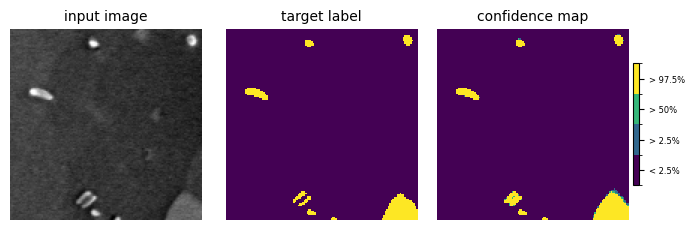

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(textwidth, textwidth / 3.1))
plot_confidence_map_and_input(model, trainer, test_loader, optimal_T, device=device_name, index=18, axs=axs, fig=fig)

## Figure for supplementary material

/home/korten76/workspace/chekhonin-automatic-carbide-detection/venv/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/korten76/workspace/chekhonin-automatic-carbide ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/home/korten76/workspace/chekhonin-automatic-carbide-detection/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

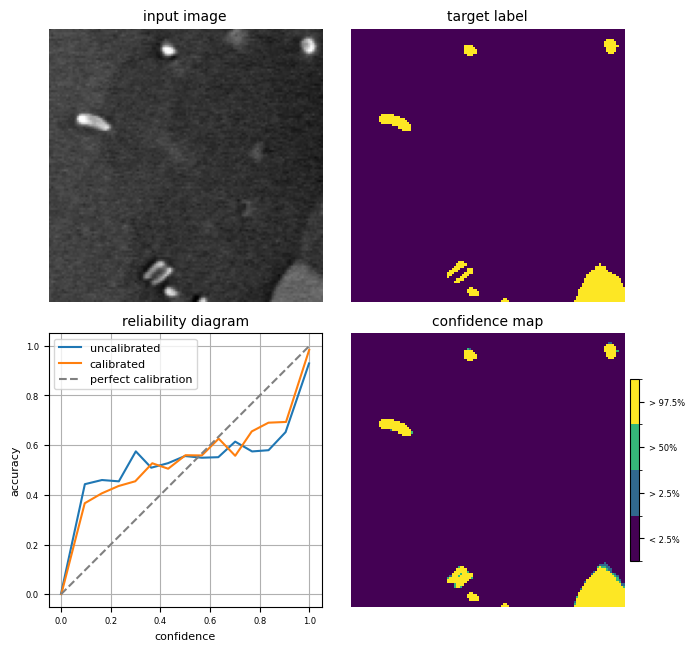

In [21]:
layout = [["input", "labels"], ["rel", "conf"]]
fig, axs_dic = plt.subplot_mosaic(layout, figsize=(textwidth, textwidth * 0.93))
ax = list(axs_dic.values())
plot_confidence_map_and_input(
    model, trainer, test_loader, optimal_T, device=device_name, index=18, axs=[ax[i] for i in (0, 1, 3)], fig=fig
)
plot_reliability_diagram(logits, labels, temperature=optimal_T, ax=ax[2])
# make axis[2] the same size as axis[0] and axis[1]
ax[2].set_box_aspect(1)  # Set aspect ratio to be 1:1 (square)
fig.tight_layout()
fig.savefig(figure_path / "reliability_and_confidence_map.svg", bbox_inches='tight', dpi=300)